In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
df_tran = pd.read_csv('../dataset/tran.txt',names=['primary-date','time','approximate-indicator','secondary-date','approximate-indicator',
  'transaction-ID','player','type','from-team','from-league','to-team','to-league','draft-type','draft-round','pick-number','info'])
df_playerid = pd.read_csv('../dataset/playerid_list.csv',names=['LASTNAME','FIRSTNAME','PLAYERID','DAVENPORTCODE','MLBCODE','player'],skiprows=1);
df_master = pd.read_csv('../dataset/Master.csv')
df_batstat = pd.read_csv('../dataset/war_daily_bat.txt')
df_pitchstat = pd.read_csv('../dataset/war_daily_pitch.txt')
pd.set_option('display.max_columns', 60)

# Data Cleanup
# Recontructing invalid dates
df_tran['primary-date'] = df_tran['primary-date'].astype('str')
df_tran['primary-date'] = df_tran['primary-date'].str.replace(r'\A(\d{4})[0]{4}', r'\g<1>0101')
df_tran['primary-date'] = df_tran['primary-date'].str.replace(r'\A(\d{4})(..)[0]{2}', r'\g<1>\g<2>01')

#Extracting only trades from transaction dataframe
df_tran = df_tran[df_tran['type'] == "T "]
df_tran = df_tran[df_tran['to-league'].isin(['AL','NL'])]
df_tran = df_tran[df_tran['from-league'].isin(['AL','NL'])]

df_tran['primary-date'] = pd.to_datetime(df_tran['primary-date'], format='%Y%m%d')
df_tran['tranYear'] = df_tran['primary-date'].apply(lambda x : int(x.year))

/home/piyush/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Baseline Model

In [2]:
df_master['player_ID'] = df_master['bbrefID']
df_batstat = pd.merge(df_batstat,df_master[['player_ID','retroID']],on='player_ID',how='inner')
df_pitchstat = pd.merge(df_batstat,df_master[['player_ID','retroID']],on='player_ID',how='inner')

In [3]:
df_batstat.head()

,name_common,age,mlb_ID,player_ID,year_ID,team_ID,stint_ID,lg_ID,PA,G,Inn,runs_bat,runs_br,runs_dp,runs_field,runs_infield,runs_outfield,runs_catcher,runs_good_plays,runs_defense,runs_position,runs_position_p,runs_replacement,runs_above_rep,runs_above_avg,runs_above_avg_off,runs_above_avg_def,WAA,WAA_off,WAA_def,WAR,WAR_def,WAR_off,WAR_rep,salary,pitcher,teamRpG,oppRpG,oppRpPA_rep,oppRpG_rep,pyth_exponent,pyth_exponent_rep,waa_win_perc,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep,OPS_plus,TOB_lg,TB_lg,retroID
0,David Aardsma,22.0,430911.0,aardsda01,2004,SFG,1,NL,0,11,10.7,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.00,0.0,0.1,0.1,0.1,0.1,0.01,0.01,0.00,0.01,0.00,0.01,0.0,300000.0,Y,4.67546,4.67092,0.08651,4.67092,1.891,1.890,0.5005,0.5005,0.5005,0.5000,NaN,0.000,0.000,aardd001
1,David Aardsma,24.0,430911.0,aardsda01,2006,CHC,1,NL,3,45,53.0,-0.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.21,0.46,0.0,-0.2,-0.2,-0.2,0.2,-0.02,-0.02,0.00,-0.02,0.00,-0.02,0.0,NaN,Y,4.86164,4.86675,0.09085,4.86467,1.912,1.913,0.4995,0.4995,0.5005,0.4998,-100.0,0.694,0.896,aardd001
2,David Aardsma,25.0,430911.0,aardsda01,2007,CHW,1,AL,0,25,32.3,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.11,0.00,0.0,0.1,0.1,0.1,0.1,0.01,0.01,0.02,0.01,0.02,0.01,0.0,387500.0,Y,4.86335,4.85895,0.08422,4.85895,1.912,1.912,0.5004,0.5004,0.5004,0.5000,NaN,0.000,0.000,aardd001
3,David Aardsma,26.0,430911.0,aardsda01,2008,BOS,1,AL,1,47,48.7,-0.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.22,0.14,0.0,0.1,0.1,0.1,0.2,0.00,0.00,0.05,0.00,0.05,0.00,0.0,403250.0,Y,4.70549,4.70400,0.08092,4.70321,1.894,1.894,0.5001,0.5001,0.5005,0.4999,-100.0,0.345,0.434,aardd001
4,David Aardsma,27.0,430911.0,aardsda01,2009,SEA,1,AL,0,73,71.3,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32,0.00,0.0,0.3,0.3,0.3,0.3,0.03,0.03,0.06,0.03,0.06,0.03,0.0,419000.0,Y,4.80227,4.79788,0.08302,4.79788,1.905,1.905,0.5004,0.5004,0.5004,0.5000,NaN,0.000,0.000,aardd001


In [4]:
#Calculates the absolute difference between two sides of a trade by summing the WAR values of each player on each side for 
#the year in which the trade took place
def trade_value(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    player_vals = []
    for x in teams:
        val = 0
        for index, row in td.iterrows():
            #val = 0
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction 
                    continue
                player_df = df_batstat[(df_batstat['retroID'] == row['player'])]
                player_df_year = player_df[(df_batstat['year_ID'] == row['tranYear'])]
                if not player_df_year.empty:
                    val += float(player_df_year[metric].iloc[0])
                elif not player_df.empty:
                    # take a random value if we don't have war for that transaction year, put logic to change this to nearest year
                    val += float(player_df['WAR'].iloc[0])
                else:
                    ## figure out a way to find war for these players
                    val += 0
        player_vals.append(val)
    return abs(player_vals[1]-player_vals[0])

In [5]:
#Calculates the absolute difference between two sides of a trade by summing the WAR values of each player on each side one
# year after the trade took place
def trade_value_next(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    player_vals = []
    for x in teams:
        val = 0
        for index, row in td.iterrows():
            #val = 0
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction 
                    continue
                player_df = df_batstat[(df_batstat['retroID'] == row['player'])]
                player_df_year = player_df[(df_batstat['year_ID'] == row['tranYear'])]
                player_df_year_next = player_df[(df_batstat['year_ID'] == (row['tranYear'] + 1))]
                if not player_df_year_next.empty:
                    # get the value of metric one year after trade
                    val += float(player_df_year_next[metric].iloc[0])
                elif not player_df_year.empty:
                    # if can't find above value assume its the same as the last year's value 
                    val += float(player_df_year[metric].iloc[0])
                elif not player_df.empty:
                    # take a random value if we don't have war for that transaction year, put logic to change this to nearest year
                    val += float(player_df[metric].iloc[0])
                else:
                    ## figure out a way to find war for these players
                    val += 0
        player_vals.append(val)
    return (abs(player_vals[1]-player_vals[0]),tranID)

In [6]:
#Calculating the trade value difference for each transaction using metric WAR,WAA,PA,Salary & TA
trade_val_list_WAR = []
transactions = df_tran['transaction-ID'].unique()
for x in transactions:
    trade_val_list_WAR.append(trade_value(x,'WAR'))

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<function matplotlib.pyplot.show>

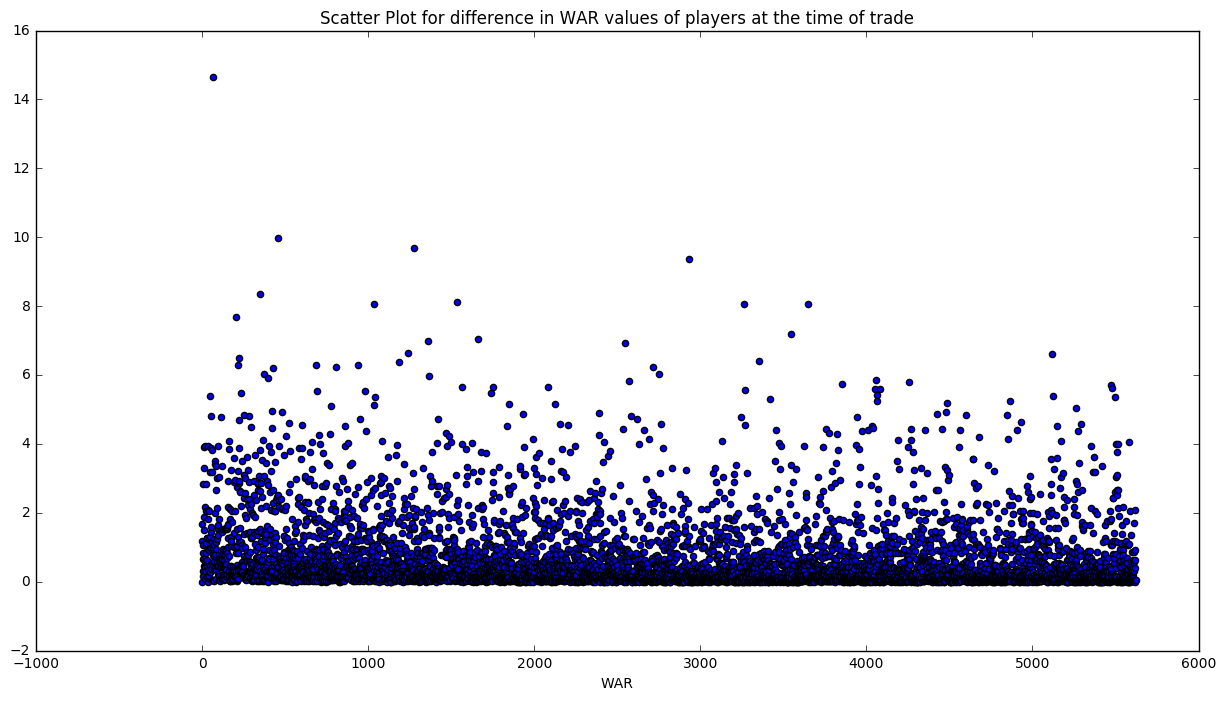

In [7]:
# Scatter plot for Wins Above Replacement
x_pos = np.arange(0,len(trade_val_list_WAR))
plt.figure(figsize=(15, 8))
plt.title("Scatter Plot for difference in WAR values of players at the time of trade")
plt.xlabel("WAR")
plt.scatter(x_pos, trade_val_list_WAR)
plt.show

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<function matplotlib.pyplot.show>

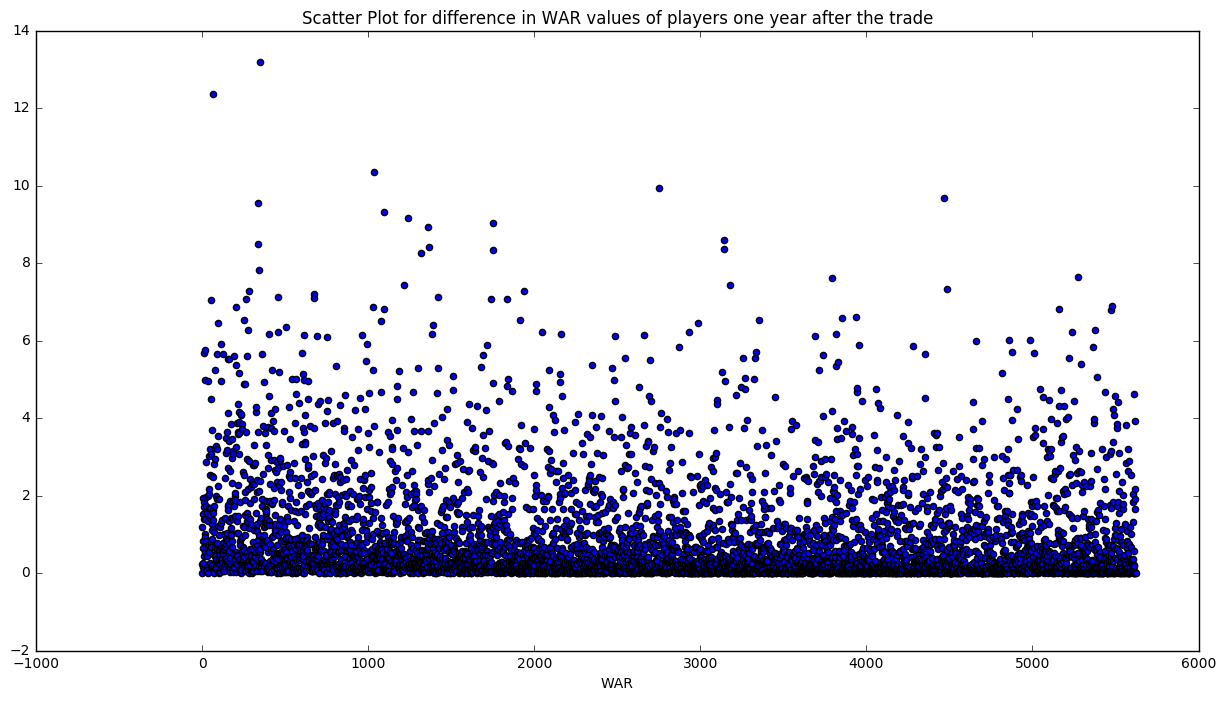

In [8]:
trade_val_list_WAR_next = []
transactions = df_tran['transaction-ID'].unique()
for x in transactions:
    trade_val_list_WAR_next.append(trade_value_next(x,'WAR'))
    
#trade_val_list
new_trade_val_list_WAR_next =[]
for i in trade_val_list_WAR_next:
    new_trade_val_list_WAR_next.append(i[0])
    
x_pos = np.arange(0,len(new_trade_val_list_WAR_next))
plt.figure(figsize=(15, 8))
plt.title("Scatter Plot for difference in WAR values of players one year after the trade")
plt.xlabel("WAR")
plt.scatter(x_pos, new_trade_val_list_WAR_next)
plt.show

In [9]:
# sorting values based on difference in WAR scores
sorted_trade_df = sorted(trade_val_list_WAR_next,key=lambda x:x[0],reverse=True)
sorted_trade_df

[(13.18, 48741),
 (12.36, 48301),
 (10.36, 49585),
 (9.94, 51311),
 (9.69, 53021),
 (9.549999999999999, 57890),
 (9.32, 49648),
 (9.169999999999998, 49800),
 (9.020000000000001, 50311),
 (8.94, 49917),
 (8.59, 51700),
 (8.479999999999999, 48725),
 (8.42, 49926),
 (8.37, 51699),
 (8.329999999999998, 50308),
 (8.25, 49877),
 (7.82, 48739),
 (7.64, 68642),
 (7.62, 52350),
 (7.44, 51738),
 (7.4399999999999995, 49777),
 (7.33, 53039),
 (7.29, 72357),
 (7.2700000000000005, 48638),
 (7.1899999999999995, 49167),
 (7.12, 48912),
 (7.11, 49979),
 (7.09, 49168),
 (7.08, 50391),
 (7.060000000000001, 72343),
 (7.06, 48614),
 (7.040000000000001, 48277),
 (6.9, 74678),
 (6.869999999999999, 49579),
 (6.86, 65088),
 (6.819999999999999, 49649),
 (6.81, 68169),
 (6.8, 74575),
 (6.609999999999999, 52497),
 (6.590000000000001, 52415),
 (6.53, 59767),
 (6.53, 50469),
 (6.52, 51911),
 (6.51, 49633),
 (6.46, 54055),
 (6.45, 51543),
 (6.3999999999999995, 49947),
 (6.34, 48975),
 (6.2700000000000005, 75894),
 (

In [10]:
df_batstat.head()

,name_common,age,mlb_ID,player_ID,year_ID,team_ID,stint_ID,lg_ID,PA,G,Inn,runs_bat,runs_br,runs_dp,runs_field,runs_infield,runs_outfield,runs_catcher,runs_good_plays,runs_defense,runs_position,runs_position_p,runs_replacement,runs_above_rep,runs_above_avg,runs_above_avg_off,runs_above_avg_def,WAA,WAA_off,WAA_def,WAR,WAR_def,WAR_off,WAR_rep,salary,pitcher,teamRpG,oppRpG,oppRpPA_rep,oppRpG_rep,pyth_exponent,pyth_exponent_rep,waa_win_perc,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep,OPS_plus,TOB_lg,TB_lg,retroID
0,David Aardsma,22.0,430911.0,aardsda01,2004,SFG,1,NL,0,11,10.7,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.00,0.0,0.1,0.1,0.1,0.1,0.01,0.01,0.00,0.01,0.00,0.01,0.0,300000.0,Y,4.67546,4.67092,0.08651,4.67092,1.891,1.890,0.5005,0.5005,0.5005,0.5000,NaN,0.000,0.000,aardd001
1,David Aardsma,24.0,430911.0,aardsda01,2006,CHC,1,NL,3,45,53.0,-0.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.21,0.46,0.0,-0.2,-0.2,-0.2,0.2,-0.02,-0.02,0.00,-0.02,0.00,-0.02,0.0,NaN,Y,4.86164,4.86675,0.09085,4.86467,1.912,1.913,0.4995,0.4995,0.5005,0.4998,-100.0,0.694,0.896,aardd001
2,David Aardsma,25.0,430911.0,aardsda01,2007,CHW,1,AL,0,25,32.3,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.11,0.00,0.0,0.1,0.1,0.1,0.1,0.01,0.01,0.02,0.01,0.02,0.01,0.0,387500.0,Y,4.86335,4.85895,0.08422,4.85895,1.912,1.912,0.5004,0.5004,0.5004,0.5000,NaN,0.000,0.000,aardd001
3,David Aardsma,26.0,430911.0,aardsda01,2008,BOS,1,AL,1,47,48.7,-0.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.22,0.14,0.0,0.1,0.1,0.1,0.2,0.00,0.00,0.05,0.00,0.05,0.00,0.0,403250.0,Y,4.70549,4.70400,0.08092,4.70321,1.894,1.894,0.5001,0.5001,0.5005,0.4999,-100.0,0.345,0.434,aardd001
4,David Aardsma,27.0,430911.0,aardsda01,2009,SEA,1,AL,0,73,71.3,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32,0.00,0.0,0.3,0.3,0.3,0.3,0.03,0.03,0.06,0.03,0.06,0.03,0.0,419000.0,Y,4.80227,4.79788,0.08302,4.79788,1.905,1.905,0.5004,0.5004,0.5004,0.5000,NaN,0.000,0.000,aardd001


In [11]:
df_batstat_sort = df_batstat.sort('age')
df_batstat_sort = df_batstat_sort[pd.notnull(df_batstat_sort['age'])]

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [12]:
df_batstat_sort

,name_common,age,mlb_ID,player_ID,year_ID,team_ID,stint_ID,lg_ID,PA,G,Inn,runs_bat,runs_br,runs_dp,runs_field,runs_infield,runs_outfield,runs_catcher,runs_good_plays,runs_defense,runs_position,runs_position_p,runs_replacement,runs_above_rep,runs_above_avg,runs_above_avg_off,runs_above_avg_def,WAA,WAA_off,WAA_def,WAR,WAR_def,WAR_off,WAR_rep,salary,pitcher,teamRpG,oppRpG,oppRpPA_rep,oppRpG_rep,pyth_exponent,pyth_exponent_rep,waa_win_perc,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep,OPS_plus,TOB_lg,TB_lg,retroID
67744,Joe Nuxhall,15.0,119872.0,nuxhajo01,1944,CIN,1,NL,0,1,NaN,0.00,0.00,0.00,0.0,NaN,NaN,NaN,NaN,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1350.0,Y,4.25962,4.25962,0.07681,4.25962,1.841,1.841,0.5000,0.5000,0.5000,0.5000,NaN,0.000,0.000,nuxhj101
60291,Roger McKee,16.0,118770.0,mckeero01,1943,PHI,1,NL,6,4,NaN,-0.20,0.00,0.00,0.0,NaN,NaN,NaN,NaN,0.0,0.00,0.50,0.00,0.3,0.3,0.3,0.0,0.03,0.03,0.00,0.03,0.00,0.03,0.00,NaN,Y,3.98411,3.90911,0.06831,3.86136,1.802,1.794,0.5086,0.5086,0.5000,0.4945,59.040513,1.959,1.756,mcker101
22710,Jim Derrington,16.0,113286.0,derriji01,1956,CHW,1,AL,2,1,6.0,0.17,0.00,0.00,0.0,0.0,0.0,0.0,NaN,0.0,0.00,0.22,0.00,0.4,0.4,0.4,0.0,0.04,0.04,0.00,0.04,0.00,0.04,0.00,NaN,Y,5.06845,4.67845,0.08601,4.61711,1.913,1.888,0.5382,0.5382,0.5000,0.4938,164.604572,0.701,0.820,derrj101
82050,Carl Scheib,16.0,121788.0,scheica01,1943,PHA,1,AL,5,6,NaN,-1.20,0.00,0.00,0.0,NaN,NaN,NaN,NaN,0.0,0.00,0.42,0.00,-0.8,-0.8,-0.8,0.0,-0.09,-0.09,0.00,-0.09,0.00,-0.09,0.00,NaN,Y,3.70083,3.83083,0.06966,3.80680,1.778,1.785,0.4847,0.4847,0.5000,0.4972,-100.000000,1.646,1.760,schec101
87677,Joe Stanley,16.0,122671.0,stanljo02,1897,WHS,1,NL,1,1,NaN,-0.39,0.00,0.00,0.0,NaN,NaN,NaN,NaN,0.0,0.00,0.08,0.00,-0.3,-0.3,-0.3,0.0,-0.03,-0.03,0.00,-0.03,0.00,-0.03,0.00,NaN,Y,5.78581,6.09581,0.11456,6.06164,2.025,2.038,0.4736,0.4736,0.5000,0.4971,-100.000000,0.361,0.395,stanj103
12870,Putsy Caballero,16.0,111846.0,cabalpu01,1944,PHI,1,NL,4,4,NaN,-0.99,0.00,0.00,-1.0,NaN,NaN,NaN,NaN,-1.0,0.00,0.00,0.13,-1.9,-2.0,-1.0,-1.0,-0.21,-0.11,-0.11,-0.20,-0.11,-0.10,0.01,NaN,N,4.01212,4.25962,0.07681,4.22779,1.826,1.840,0.4464,0.4727,0.4735,0.4965,-100.000000,1.319,1.479,cabap101
32287,Alex George,16.0,114701.0,georgal01,1955,KCA,1,AL,11,5,18.0,-1.75,0.01,0.00,-1.5,0.0,0.0,0.0,NaN,-1.5,0.13,0.00,0.34,-2.8,-3.1,-1.6,-1.4,-0.32,-0.17,-0.14,-0.28,-0.14,-0.13,0.04,NaN,N,4.14152,4.46352,0.08145,4.39604,1.847,1.862,0.4351,0.4655,0.4721,0.4929,-22.256129,3.806,3.969,geora101
71001,Frank Pearce,16.0,120328.0,pearcfr01,1876,LOU,1,NL,2,1,NaN,-0.46,0.00,0.00,0.0,NaN,NaN,NaN,NaN,0.0,0.00,0.03,0.00,-0.4,-0.4,-0.4,0.0,-0.04,-0.04,0.00,-0.04,0.00,-0.04,0.00,NaN,Y,5.25047,5.68047,0.11716,5.61213,1.977,1.995,0.4612,0.4612,0.5000,0.4940,-100.000000,0.591,0.685,pearf103
24373,Jacob Doyle,16.0,113529.0,doylejo01,1872,NAT,1,NaN,41,9,NaN,-3.43,0.11,0.00,-6.0,NaN,NaN,NaN,NaN,-6.0,0.55,0.00,1.40,-7.4,-8.8,-2.8,-5.4,-0.55,-0.18,-0.33,-0.42,-0.33,-0.05,0.13,NaN,N,8.79115,9.09893,0.19447,8.94326,2.275,2.281,0.4399,0.4804,0.4631,0.4902,56.271135,13.575,15.949,doylj102
59889,Willie McGill,16.0,118703.0,mcgilwi01,1890,CLE,1,PL,90,24,NaN,-3.90,0.20,0.00,0.0,NaN,NaN,NaN,NaN,0.0,-0.09,6.71,0.00,2.9,2.9,2.9,-0.1,0.24,0.22,0.02,0.24,0.02,0.22,0.00,NaN,Y,7.12158,6.99992,0.14490,6.90992,2.127,2.118,0.5092,0.5092,0.4997,0.4931,48.987507,31.329,25.616,mcgiw101


In [13]:
agedict = {}
#print df_batstat_sort.age
for index, row in df_batstat_sort.iterrows():
    if(row['age'] in agedict):
        agedict[row['age']].append(row['WAR'])
    else:
        agedict[row['age']] = [row['WAR']]
    
    

In [14]:
#agedict[16.0]

In [15]:
age = []
avg_WAR= []
i=0
for key in agedict:
    if (~np.isnan(key)):
        avg = np.nansum(agedict[key]) / float(len(agedict[key]))
        age.append(key)
        avg_WAR.append(avg)
        


In [16]:
age_df = pd.DataFrame({ 'Age' : age,'Average_WAR' : avg_WAR}).sort('Age')

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [17]:
#age_df
def getAvgWarForAge(age):
    return (age_df[(age_df['Age'] == age)]['Average_WAR']).iloc[0]

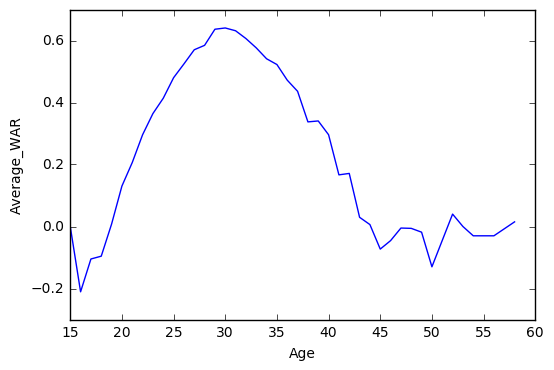

In [18]:
plt.xlabel("Age")
plt.ylabel("Average_WAR")
plt.plot(age_df.Age, age_df.Average_WAR);

In [19]:
#Calculates the absolute difference between two sides of a trade by summing the WAR values of each player on each side one
# year after the trade took place
def trade_value_diff(tranID,metric):
    td = df_tran[(df_tran['transaction-ID'] == tranID)]
    teams = td['from-team'].unique()
    val = 0
    player_vals = []
    for x in teams:
        val = 0
        for index, row in td.iterrows():
            #val = 0
            if (row['from-team'] == x):
                if pd.isnull(row['player']):
                    # filter out cash transactions or yet to be named player transaction
                    continue
                player_df = df_batstat[(df_batstat['retroID'] == row['player'])]
                player_df_year = player_df[(df_batstat['year_ID'] == row['tranYear'])]
                #instead need a df for the player after the trans year, and not just next, but all consecutive years
                for i in range(15):
                    player_df_year_next = player_df[(df_batstat['year_ID'] == (row['tranYear'] + i))]
                    if not player_df_year_next.empty:
                        # get the value of metric for each year after trade until 15 years else assume 0
                        val += float(player_df_year_next[metric].iloc[0]) - getAvgWarForAge(player_df_year_next['age'].iloc[0])
                        #val += float(player_df_year_next[metric].iloc[0])
                    #elif not player_df_year.empty:
                        # if can't find above value assume its the same as the last year's value
                        #val += float(player_df_year[metric].iloc[0])
                    #elif not player_df.empty:
                        # take a random value if we don't have war for that transaction year, put logic to change this to nearest year
                        #val += float(player_df[metric].iloc[0])
                    else:
                        ## figure out a way to find war for these players
                        val += 0
        player_vals.append(val)
    return (abs(player_vals[1]-player_vals[0]),tranID)

/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/piyush/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


<function matplotlib.pyplot.show>

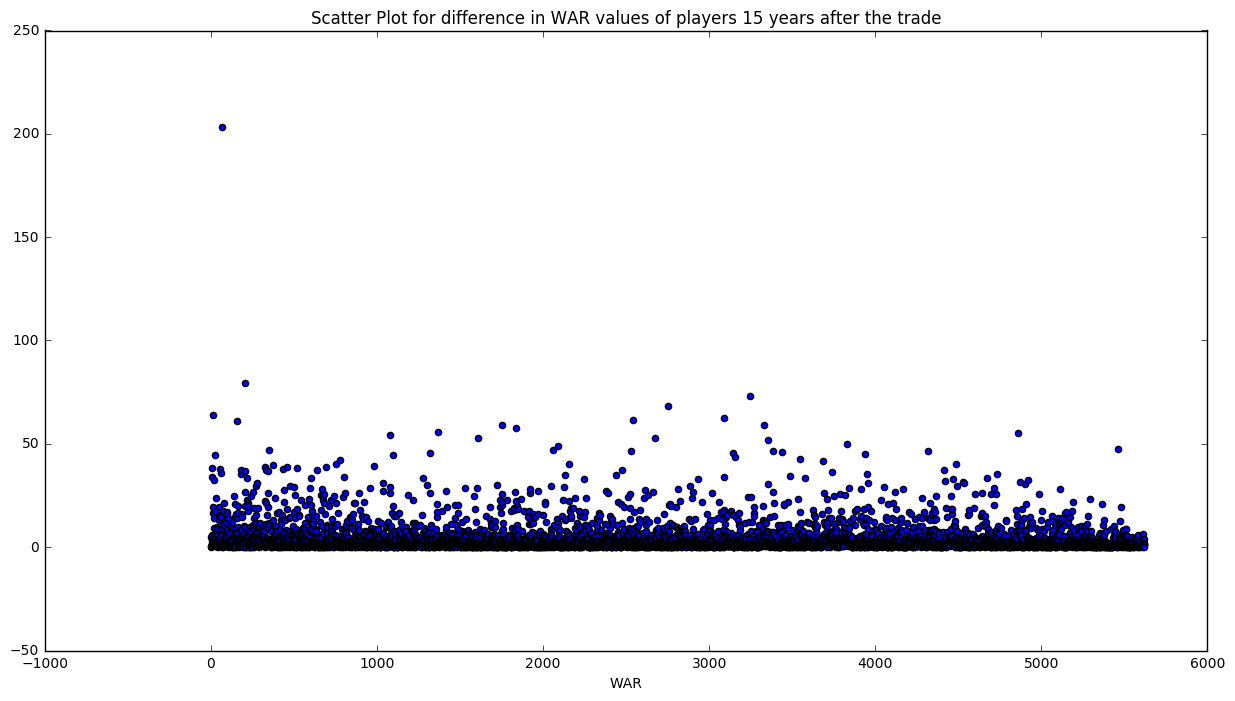

In [20]:
trade_val_list_WAR_diff = []
transactions = df_tran['transaction-ID'].unique()
for x in transactions:
    trade_val_list_WAR_diff.append(trade_value_diff(x,'WAR'))
   
#trade_val_list
new_trade_val_list_WAR_diff =[]
for i in trade_val_list_WAR_diff:
    new_trade_val_list_WAR_diff.append(i[0])
   
x_pos = np.arange(0,len(new_trade_val_list_WAR_diff))
plt.figure(figsize=(15, 8))
plt.title("Scatter Plot for difference in WAR values of players 15 years after the trade")
plt.xlabel("WAR")
plt.scatter(x_pos, new_trade_val_list_WAR_diff)
plt.show

In [21]:
# sorting values based on difference in WAR scores
sorted_trade_df_new = sorted(trade_val_list_WAR_diff,key=lambda x:x[0],reverse=True)
sorted_trade_df_new

[(203.13536375231803, 48301),
 (79.202935024473334, 65088),
 (73.083465672143859, 51801),
 (68.163468907805054, 51311),
 (63.858807001634517, 48235),
 (62.525871378847185, 51648),
 (61.391467279461935, 51102),
 (61.076798906074124, 48448),
 (59.053398273339326, 51890),
 (58.872620408743579, 50308),
 (57.575737143245441, 50393),
 (55.518229007585205, 49926),
 (55.014483254967509, 54754),
 (54.234284704169518, 49629),
 (52.927709954735391, 51231),
 (52.877417865897726, 50167),
 (52.048467344994798, 51911),
 (49.821980873463239, 52387),
 (48.84936780340832, 50648),
 (47.623389182632515, 74045),
 (47.205809248763053, 50620),
 (47.127664181250907, 48746),
 (46.578356275353784, 51087),
 (46.463198787969418, 52877),
 (46.385891233191266, 51941),
 (45.980878065832982, 52000),
 (45.520810752427842, 51700),
 (45.333879670309443, 49877),
 (45.063757889448318, 52497),
 (44.449566648598591, 48244),
 (44.430717492199442, 49648),
 (43.681475427822562, 51715),
 (42.742585402766068, 52106),
 (42.289621

In [22]:
df_tran[df_tran['transaction-ID'] == 48448]

,primary-date,time,approximate-indicator,secondary-date,approximate-indicator,transaction-ID,player,type,from-team,from-league,to-team,to-league,draft-type,draft-round,pick-number,info,tranYear
59537,1910-07-23,NaN,NaN,NaN,NaN,48448,rathm101,T,PHA,AL,CLE,AL,NaN,NaN,NaN,NaN,1910
59538,1910-07-23,NaN,NaN,NaN,NaN,48448,lordb101,T,CLE,AL,PHA,AL,NaN,NaN,NaN,NaN,1910
59539,1910-07-30,NaN,NaN,NaN,NaN,48448,jackj101,T,PHA,AL,CLE,AL,NaN,NaN,NaN,NaN,1910


In [23]:
df_master[df_master['retroID']=='jackj101']

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,deathCountry,deathState,deathCity,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID,player_ID
8212,jacksjo01,1887.0,7.0,16.0,USA,SC,Pickens County,1951.0,12.0,5.0,USA,SC,Greenville,Shoeless Joe,Jackson,Joseph Walker,200.0,73.0,L,R,1908-08-25,1920-09-27,jackj101,jacksjo01,jacksjo01


In [24]:
df_pitchstat

,name_common,age,mlb_ID,player_ID,year_ID,team_ID,stint_ID,lg_ID,PA,G,Inn,runs_bat,runs_br,runs_dp,runs_field,runs_infield,runs_outfield,runs_catcher,runs_good_plays,runs_defense,runs_position,runs_position_p,runs_replacement,runs_above_rep,runs_above_avg,runs_above_avg_off,runs_above_avg_def,WAA,WAA_off,WAA_def,WAR,WAR_def,WAR_off,WAR_rep,salary,pitcher,teamRpG,oppRpG,oppRpPA_rep,oppRpG_rep,pyth_exponent,pyth_exponent_rep,waa_win_perc,waa_win_perc_off,waa_win_perc_def,waa_win_perc_rep,OPS_plus,TOB_lg,TB_lg,retroID_x,retroID_y
0,David Aardsma,22.0,430911.0,aardsda01,2004,SFG,1,NL,0,11,10.7,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.00,0.00,0.1,0.1,0.1,0.1,0.01,0.01,0.00,0.01,0.00,0.01,0.00,300000.0,Y,4.67546,4.67092,0.08651,4.67092,1.891,1.890,0.5005,0.5005,0.5005,0.5000,NaN,0.000,0.000,aardd001,aardd001
1,David Aardsma,24.0,430911.0,aardsda01,2006,CHC,1,NL,3,45,53.0,-0.90,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.21,0.46,0.00,-0.2,-0.2,-0.2,0.2,-0.02,-0.02,0.00,-0.02,0.00,-0.02,0.00,NaN,Y,4.86164,4.86675,0.09085,4.86467,1.912,1.913,0.4995,0.4995,0.5005,0.4998,-100.000000,0.694,0.896,aardd001,aardd001
2,David Aardsma,25.0,430911.0,aardsda01,2007,CHW,1,AL,0,25,32.3,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.11,0.00,0.00,0.1,0.1,0.1,0.1,0.01,0.01,0.02,0.01,0.02,0.01,0.00,387500.0,Y,4.86335,4.85895,0.08422,4.85895,1.912,1.912,0.5004,0.5004,0.5004,0.5000,NaN,0.000,0.000,aardd001,aardd001
3,David Aardsma,26.0,430911.0,aardsda01,2008,BOS,1,AL,1,47,48.7,-0.29,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.22,0.14,0.00,0.1,0.1,0.1,0.2,0.00,0.00,0.05,0.00,0.05,0.00,0.00,403250.0,Y,4.70549,4.70400,0.08092,4.70321,1.894,1.894,0.5001,0.5001,0.5005,0.4999,-100.000000,0.345,0.434,aardd001,aardd001
4,David Aardsma,27.0,430911.0,aardsda01,2009,SEA,1,AL,0,73,71.3,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.32,0.00,0.00,0.3,0.3,0.3,0.3,0.03,0.03,0.06,0.03,0.06,0.03,0.00,419000.0,Y,4.80227,4.79788,0.08302,4.79788,1.905,1.905,0.5004,0.5004,0.5004,0.5000,NaN,0.000,0.000,aardd001,aardd001
5,David Aardsma,28.0,430911.0,aardsda01,2010,SEA,1,AL,0,53,49.7,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.00,0.00,0.2,0.2,0.2,0.2,0.03,0.03,0.06,0.03,0.06,0.03,0.00,2750000.0,Y,4.45156,4.44684,0.07567,4.44684,1.864,1.864,0.5005,0.5005,0.5005,0.5000,NaN,0.000,0.000,aardd001,aardd001
6,David Aardsma,30.0,430911.0,aardsda01,2012,NYY,1,AL,0,1,1.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,500000.0,Y,4.41052,4.41052,0.07575,4.41052,1.860,1.860,0.5000,0.5000,0.5000,0.5000,NaN,0.000,0.000,aardd001,aardd001
7,David Aardsma,31.0,430911.0,aardsda01,2013,NYM,1,NL,0,43,39.7,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.22,0.00,0.00,0.2,0.2,0.2,0.2,0.03,0.03,-0.01,0.03,-0.01,0.03,0.00,NaN,Y,4.03312,4.02801,0.07154,4.02801,1.813,1.812,0.5006,0.5006,0.5006,0.5000,NaN,0.000,0.000,aardd001,aardd001
8,David Aardsma,33.0,430911.0,aardsda01,2015,ATL,1,NL,1,30,30.7,-0.26,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.18,0.14,0.00,0.1,0.1,0.1,0.2,0.01,0.01,0.00,0.01,0.00,0.01,0.00,NaN,Y,4.22422,4.22222,0.07613,4.22114,1.837,1.837,0.5002,0.5002,0.5007,0.4999,-100.000000,0.320,0.404,aardd001,aardd001
9,Hank Aaron,20.0,110001.0,aaronha01,1954,MLN,1,NL,509,122,1031.0,3.61,-1.82,-0.48,-1.0,0.0,0.0,0.0,NaN,-1.0,-5.30,0.00,19.17,14.2,-5.0,-4.0,-6.3,-0.61,-0.40,-0.70,1.27,-0.70,1.48,1.88,6000.0,N,4.54272,4.57542,0.07746,4.41826,1.877,1.870,0.4958,0.4966,0.4947,0.4837,103.831127,169.511,193.050,aaroh101,aaroh101
